In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import with_statement
import heapq
import os
import sys
import time
import numpy as np
import time
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
from numba import jit

In [26]:
def seek(
    origins,
    targets=None,
    weights=None,
    path_handling='link',
    debug=False,
    film=False,
):
    """
    Find the shortest paths between *any* origin and *each* target.

    Pathfinder is a modified version of Dijkstra's algorithm
    (https://en.wikipedia.org/wiki/Dijkstra's_algorithm) for finding
    the shortest distance between two points in a graph. It differs in
    a few important ways:

    * It finds the shortest distance between a target point and the
        nearest of a set of origin points. This is then repeated for
        each target point.
    * It assumes a gridded topology. In other words, it knows that
        each node only
        touches its neighbors to the north, south, east, west,
        northeast, northwest, southeast, and southwest.

    Like Dijkstra's, Pathfinder assumes that all weights are 0 or greater.
    Negative weights are set to zero.  All input arrays (origins,
    targets, and weights) need to have the same number of rows and columns.

    @param origins, targets: 2D numpy array of ints
        Any non-zero values are the locations of origin and target points,
        respectively. Note that both may be modified. Target points may
        be removed, once paths to them are found and origins may be
        augmented (see path_handling param below).
        If targets is not supplied, no targets are assumed and a targets
        array of all zeros is created. This is useful for calculating minimum
        distances from a set of origins to all points of the grid.
    @param weights: 2D numpy array of floats
        The cost of visiting a grid square, zero or greater.
        For favorable (easy to traverse) grid locations, this is low.
        For unfavorable grid locations, this is high.
        If not supplied, a weights array of all ones is used. This is
        useful for calculating as-the-crow-flies distance.
    @param path_handling: string
        One of {'link', 'assimilate', 'none', 'l', 'a', 'n'}.
        Determines how to handle paths between target and origins,
        once they are found.

        * 'link' or 'l'  adds a target to the origins once it is found,
            as well as the path connecting them. This mode
            is good for growing a network by connecting nodes, as we do here
            when planning or estimating an electrical grid.
        * 'assimilate' or 'a' adds a target to the origins once it is found,
            but does not add the path connecting them. This mode
            is good for growing a network by adding nodes that
            have no physical connection between them, as in planning an
            ad-hoc wireless network.
        * 'none' or 'n' doesn't add a target to the to the origins
            once it is found. This mode is good for finding a path
            from a backbone or trunk to many leaf nodes,
            as in planning fiber backhaul routing.

    @param debug: boolean
        If True, provide text updates on the algorithm's progress.
    @param film: boolean
        If True, periodically save snapshots of the algorithm's progress.

    @retun results: dict
        'paths': 2D numpy array of ints
            1 where paths have been found, and 0 everywhere else.
        'distance: 2D numpy array of floats
            The length of the shortest path (the sum of the weights of grid
            cells traversed) from the nearest origin point to every point
            on the grid. Origin points have a distance of zero, and it
            goes up from there the further away you get.
        'rendering': 2D numpy array of floats
            An image representing the final state of the algorithm, including
            paths found and distances calculated.
    """
    if weights is None:
        weights = np.ones(origins.shape)
    if targets is None:
        targets = np.zeros(origins.shape, dtype=np.int8)
    assert targets.shape == origins.shape
    assert targets.shape == weights.shape
    path_handling = path_handling.lower()
    assert path_handling in ['none', 'n', 'assimilate', 'a', 'link', 'l']
    n_rows, n_cols = origins.shape
    if path_handling[0] == 'n':
        path_handling = 0
    elif path_handling[0] == 'a':
        path_handling = 1
    elif path_handling[0] == 'l':
        path_handling = 2

    iteration = 0
    not_visited = 9999999999.

    if film:
        frame_rate = int(1e4)
        frame_counter = 100000
        frame_dirname = 'frames'
        try:
            os.mkdir(frame_dirname)
        except Exception:
            # NBD
            pass

        cwd = os.getcwd()
        try:
            os.chdir(frame_dirname)
            for filename in os.listdir('.'):
                os.remove(filename)
        except Exception:
            print('Frame deletion failed')
        finally:
            os.chdir(cwd)

    rendering = 1. / (2. * weights)
    rendering = np.minimum(rendering, 1.)
    target_locations = np.where(targets)
    n_targets = target_locations[0].size
    n_targets_remaining = n_targets
    n_targets_remaining_update = n_targets
    for i_target, row in enumerate(target_locations[0]):
        col = target_locations[1][i_target]
        wid = 8
        rendering[
            row - wid:
            row + wid + 1,
            col - wid:
            col + wid + 1] = .5

    # The distance array shows the shortest weighted distance from
    # each point in the grid to the nearest origin point.
    distance = np.ones((n_rows, n_cols)) * not_visited
    origin_locations = np.where(origins != 0)
    distance[origin_locations] = 0.

    # The paths array shows each of the paths that are discovered
    # from targets to their nearest origin point.
    paths = np.zeros((n_rows, n_cols), dtype=np.int8)

    # The halo is the set of points under evaluation. They surround
    # the origin points and expand outward, forming a growing halo
    # around the set of origins that eventually enevlops targets.
    # It is implemented using a heap queue, so that the halo point
    # nearest to an origin is always the next one that gets evaluated.
    halo = []
    for i, origin_row in enumerate(origin_locations[0]):
        origin_col = origin_locations[1][i]
        heapq.heappush(halo, (0., (origin_row, origin_col)))

    # The temporary array for tracking locations to add to the halo.
    # This gets overwritten with each iteration.
    new_locs = np.zeros((int(1e6), 3))
    n_new_locs = 0

    while len(halo) > 0:
        iteration += 1
        if debug:
            if (n_targets_remaining > n_targets_remaining_update or
                    iteration % 1e4 == 0.):
                n_targets_remaining = n_targets_remaining_update
                print('\r {num} targets of {total} reached, {rem} remaining, {halo_len} to try '
                      .format(
                          num=n_targets - n_targets_remaining,
                          total=n_targets,
                          rem=n_targets_remaining,
                          halo_len=len(halo),
                      ), end='')
                sys.stdout.flush()
        if film:
            if iteration % frame_rate == 0:
                frame_counter = render(
                    distance,
                    frame_counter,
                    frame_dirname,
                    not_visited,
                    rendering,
                )

        # Reinitialize locations to add.
        new_locs[:n_new_locs, :] = 0.
        n_new_locs = 0

        # Retrieve and check the location with shortest distance.
        (distance_here, (row_here, col_here)) = heapq.heappop(halo)
        n_new_locs, n_targets_remaining_update = nb_loop(
            col_here,
            distance,
            distance_here,
            n_cols,
            n_new_locs,
            n_rows,
            n_targets_remaining,
            new_locs,
            not_visited,
            origins,
            path_handling,
            paths,
            row_here,
            targets,
            weights,
        )
        for i_loc in range(n_new_locs):
            loc = (int(new_locs[i_loc, 1]), int(new_locs[i_loc, 2]))
            heapq.heappush(halo, (new_locs[i_loc, 0], loc))

    if debug:
        print('\r                                                 ', end='')
        sys.stdout.flush()
        print('')
    # Add the newfound paths to the visualization.
    rendering = 1. / (1. + distance / 10.)
    rendering[np.where(origins)] = 1.
    rendering[np.where(paths)] = .8
    results = {'paths': paths, 'distance': distance, 'rendering': rendering}
    return results

def render(
    distance,
    frame_counter,
    frame_dirname,
    not_visited,
    rendering,
):
    """
    Turn the progress of the algorithm into a pretty picture.
    """
    progress = rendering.copy()
    visited_locs = np.where(distance < not_visited)
    progress[visited_locs] = 1. / (1. + distance[visited_locs] / 10.)
    filename = 'pathfinder_frame_' + str(frame_counter) + '.png'
    cmap = 'inferno'
    dpi = 1200
    plt.figure(33374)
    plt.clf()
    plt.imshow(
        progress,
        origin='upper',
        interpolation='nearest',
        cmap=plt.get_cmap(cmap),
        vmax=1.,
        vmin=0.,
    )
    filename_full = os.path.join(frame_dirname, filename)
    plt.savefig(filename_full, dpi=dpi)
    frame_counter += 1
    return frame_counter


@jit(nopython=True)
def nb_trace_back(
    distance,
    n_new_locs,
    new_locs,
    not_visited,
    origins,
    path_handling,
    paths,
    target,
    weights,
):
    """
    Connect each found electrified target to the grid through
    the shortest available path.
    """
    # Handle the case where you find more than one target.
    path = []
    distance_remaining = distance[target]
    current_location = target
    while distance_remaining > 0.:
        path.append(current_location)
        (row_here, col_here) = current_location
        # Check each of the neighbors for the lowest distance to grid.
        neighbors = [
            ((row_here - 1, col_here), 1.),
            ((row_here + 1, col_here), 1.),
            ((row_here, col_here + 1), 1.),
            ((row_here, col_here - 1), 1.),
            ((row_here - 1, col_here - 1), 2.**.5),
            ((row_here + 1, col_here - 1), 2.**.5),
            ((row_here - 1, col_here + 1), 2.**.5),
            ((row_here + 1, col_here + 1), 2.**.5),
        ]
        lowest_distance = not_visited
        # It's confusing, but keep in mind that
        # distance[neighbor] is the distance from the neighbor position
        # to the grid, while neighbor_distance is
        # the distance *through*
        # the neighbor position to the grid. It is distance[neighbor]
        # plus the distance to the neighbor from the current position.
        for (neighbor, scale) in neighbors:
            if neighbor not in path:
                distance_from_neighbor = scale * weights[current_location]
                neighbor_distance = (distance[neighbor] +
                                     distance_from_neighbor)
                if neighbor_distance < lowest_distance:
                    lowest_distance = neighbor_distance
                    best_neighbor = neighbor

        # This will fail if caught in a local minimum.
        if distance_remaining < distance[best_neighbor]:
            distance_remaining = 0.
            continue

        distance_remaining = distance[best_neighbor]
        current_location = best_neighbor

    # Add this new path.
    for i_loc, loc in enumerate(path):
        paths[loc] = 1
        # If paths are to be linked, include the entire paths as origins and
        # add them to new_locs. If targets are to be assimilated, just add
        # the target (the first point on the path) to origins and new_locs.
        if path_handling == 2 or (
                path_handling == 1 and i_loc == 0):
            origins[loc] = 1
            distance[loc] = 0.
            new_locs[n_new_locs, 0] = 0.
            new_locs[n_new_locs, 1] = loc[0]
            new_locs[n_new_locs, 2] = loc[1]
            n_new_locs += 1

    return n_new_locs


@jit(nopython=True)
def nb_loop(
    col_here,
    distance,
    distance_here,
    n_cols,
    n_new_locs,
    n_rows,
    n_targets_remaining,
    new_locs,
    not_visited,
    origins,
    path_handling,
    paths,
    row_here,
    targets,
    weights,
):
    """
    This is the meat of the computation.
    Pull the computationally expensive operations from seek()
    out into their own function that can be pre-compiled using numba.
    """
    # Calculate the distance for each of the 8 neighbors.
    neighbors = [
        ((row_here - 1, col_here), 1.),
        ((row_here + 1, col_here), 1.),
        ((row_here, col_here + 1), 1.),
        ((row_here, col_here - 1), 1.),
        ((row_here - 1, col_here - 1), 2.**.5),
        ((row_here + 1, col_here - 1), 2.**.5),
        ((row_here - 1, col_here + 1), 2.**.5),
        ((row_here + 1, col_here + 1), 2.**.5),
    ]

    for (neighbor, scale) in neighbors:
        weight = scale * weights[neighbor]
        neighbor_distance = distance_here + weight

        if distance[neighbor] == not_visited:
            if targets[neighbor]:
                n_new_locs = nb_trace_back(
                    distance,
                    n_new_locs,
                    new_locs,
                    not_visited,
                    origins,
                    path_handling,
                    paths,
                    neighbor,
                    weights,
                )
                targets[neighbor] = 0
                n_targets_remaining -= 1
        if neighbor_distance < distance[neighbor]:
            distance[neighbor] = neighbor_distance
            if (neighbor[0] > 0 and
                    neighbor[0] < n_rows - 1 and
                    neighbor[1] > 0 and
                    neighbor[1] < n_cols - 1):
                new_locs[n_new_locs, 0] = distance[neighbor]
                new_locs[n_new_locs, 1] = neighbor[0]
                new_locs[n_new_locs, 2] = neighbor[1]
                n_new_locs += 1
    return n_new_locs, n_targets_remaining


In [27]:
test_origins = np.zeros((200,200))
test_origins[100,100]  = 1
test_targets = np.zeros((200,200))
test_targets[150,150], test_targets[10, 190], test_targets[60, 18], test_targets[10, 90], test_targets[30,120] = 1, 1, 1, 1, 1

weights = [[random.random() for j in range(200)] for i in range(200)]
weights = np.array(weights)


In [28]:
out = seek(test_origins, targets=test_targets, weights=weights)

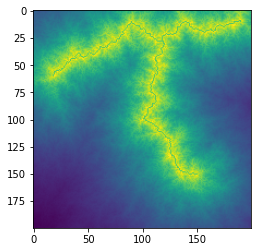

In [29]:
%matplotlib inline
plt.imshow(out['rendering'])

In [91]:
def update_weights_with_roads(weights, roads, weight):
    # assuming all road values = 1 and resulting weights should be 0.4
    assert weights.shape == roads.shape
    for i in range(roads.shape[0]):
        for j in range(roads.shape[1]):
            if roads[i][j] == 1:
                weights[i][j] = min(weights[i][j], weight)
    return weights
def update_weights_with_grid(weights, grid):
    # assuming all HV grid values > 0 and resulting weights should be ~0
    assert weights.shape == grid.shape
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i][j] > 0:
                weights[i][j] = min(weights[i][j], 0.00001)
    return weights
def validate(true, pred):
    """
        Takes ground truth and predicted values as input, returns:
        precision: a low score indicates overestimation of positives
        accuracy: heavly influenced by the number of true negatives
        iou: excludes true negatives, above 50% is satisfactory in object detection
    """
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(true.flatten(), pred.flatten()).ravel()
    precision = 100*(tp/(tp+fp))
    accuracy = 100*(tp+tn)/(tp+tn+fp+fn)
    iou = 100*(tp)/(tp+fn+fp)
    return precision, accuracy, iou

def buffered_validation(true, prediction, pixel_buffer=1):
    tn, fp, fn, tp = 0, 0, 0, 0
    for i in range(pixel_buffer, true.shape[0]-pixel_buffer):
        for j in range(pixel_buffer, true.shape[1]-pixel_buffer):
            if prediction[i,j] == 1:
                # check if ground truth agrees
                if (true[i-pixel_buffer, j+pixel_buffer] or true[i,j+pixel_buffer] or true[i+pixel_buffer, j+pixel_buffer] or
                    true[i-pixel_buffer, j] or true[i,j] or true[i+pixel_buffer, j] or 
                    true[i-pixel_buffer, j-pixel_buffer] or true[i,j-pixel_buffer] or  true[i+pixel_buffer, j-pixel_buffer]):
                    tp += 1
                else:
                    fp +=1
            else:
                if (true[i-pixel_buffer, j+pixel_buffer] or true[i,j+pixel_buffer] or true[i+pixel_buffer, j+pixel_buffer] or
                    true[i-pixel_buffer, j] or true[i,j] or true[i+pixel_buffer, j] or 
                    true[i-pixel_buffer, j-pixel_buffer] or true[i,j-pixel_buffer] or  true[i+pixel_buffer, j-pixel_buffer]):
                    fn += 1
                else:
                    tn += 1
    precision = 100*(tp/(tp+fp))
    accuracy = 100*(tp+tn)/(tp+tn+fp+fn)
    iou = 100*(tp)/(tp+fn+fp)
    return precision, accuracy, iou

In [92]:
### Initiates all data files, needs to be ran for every iteration of seek()

uganda = Image.open('datasets/uganda/bv_ww_062020.tif')
uganda = np.array(uganda)
uganda_targets = (lambda x: x>0.6)(uganda)*1

uganda_grid = Image.open('datasets/uganda/grid.tif')
uganda_grid = np.array(uganda_grid)
uganda_grid = (lambda x: x>1)(uganda_grid)*1

uganda_origin = np.zeros(uganda_targets.shape)
uganda_origin[950][741] = 1

uganda_weights = np.ones(uganda_targets.shape)
road_weights = {
    'primary_roads': 0.1,
    'secondary_roads': 0.25,
    'tertiary_roads': 0.4,
    'service_roads': 0.8,
    'unclassified_roads': 0.6
}
roads = {}
base_path = 'datasets/uganda/roads/'
roads_list = [path for path in os.listdir(base_path) if path[-3:] == 'tif']

print("before", np.histogram(uganda_weights))

for road_type in roads_list:
    r = Image.open(base_path+road_type)
    r = np.array(r)
    r = (lambda x:x==1)(r)*1
    update_weights_with_roads(uganda_weights, r, road_weights[road_type[:-4]])

uganda_hvlines = Image.open('datasets/uganda/hv_lines.tif')
uganda_hvlines = np.array(uganda_hvlines)

update_weights_with_grid(uganda_weights, uganda_hvlines)
print("after", np.histogram(uganda_weights))

before (array([      0,       0,       0,       0,       0, 1788094,       0,
             0,       0,       0], dtype=int64), array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]))
after (array([  11410,       0,   26661,   49947,       0,  177318,       0,
          1440,       0, 1521318], dtype=int64), array([1.00000e-05, 1.00009e-01, 2.00008e-01, 3.00007e-01, 4.00006e-01,
       5.00005e-01, 6.00004e-01, 7.00003e-01, 8.00002e-01, 9.00001e-01,
       1.00000e+00]))


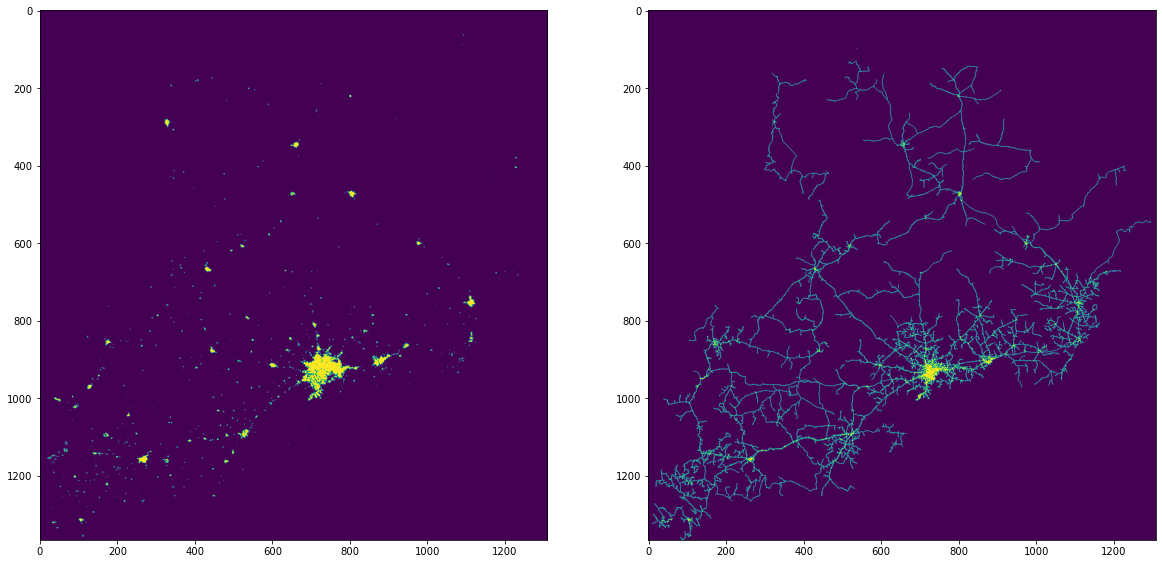

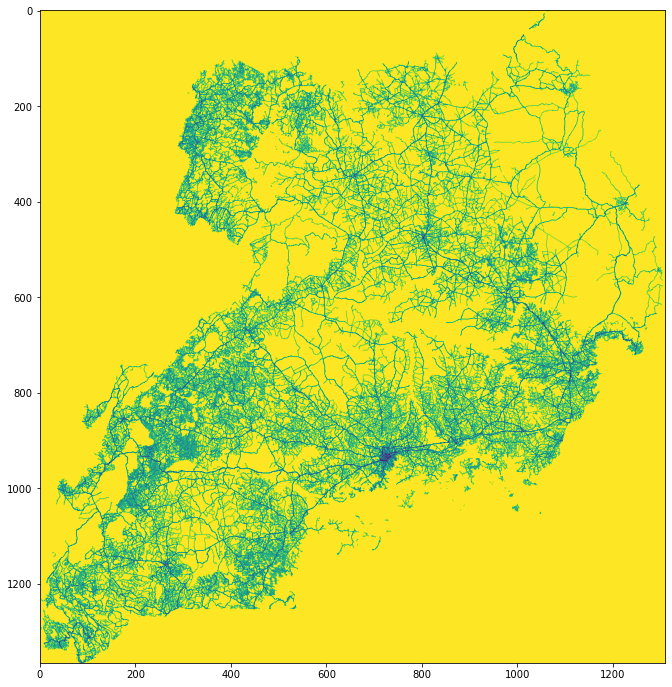

In [93]:
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(uganda_targets)
plt.subplot(122)
plt.imshow(uganda_grid)
plt.figure(figsize=(20,12))
plt.imshow(uganda_weights)

In [94]:
uganda_results = seek(
    uganda_origin,
    targets=uganda_targets,
    weights=uganda_weights,
)

In [95]:
precision, accuracy, iou = validate(uganda_grid, uganda_results['paths'])
print(precision, accuracy, iou)

# prec, acc, i = buffered_validation(uganda_grid, uganda_results['paths'], 1)
# print(prec, acc, i)

56.53447223917023 97.8541396593244 26.591287378752224


In [57]:
from osgeo import gdal, osr

origin = gdal.Open('datasets/uganda/bv_ww_062020.tif')
band = origin.GetRasterBand(1)

geotransform = origin.GetGeoTransform()
wkt = origin.GetProjection()

# Create GeoTiff file
driver = gdal.GetDriverByName("GTiff")
output_file = "results/uganda_paths.tif"

dst_ds = driver.Create(output_file,
                       band.XSize,
                       band.YSize,
                       1,
                       gdal.GDT_Int16)


# Writing output raster
dst_ds.GetRasterBand(1).WriteArray(uganda_results['paths'])
#setting nodata value
dst_ds.GetRasterBand(1).SetNoDataValue(0)
#setting extension of output raster
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
dst_ds.SetGeoTransform(geotransform)
# setting spatial reference of output raster
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
dst_ds.SetProjection(srs.ExportToWkt())
#Close output raster dataset

ds = None
dst_ds = None

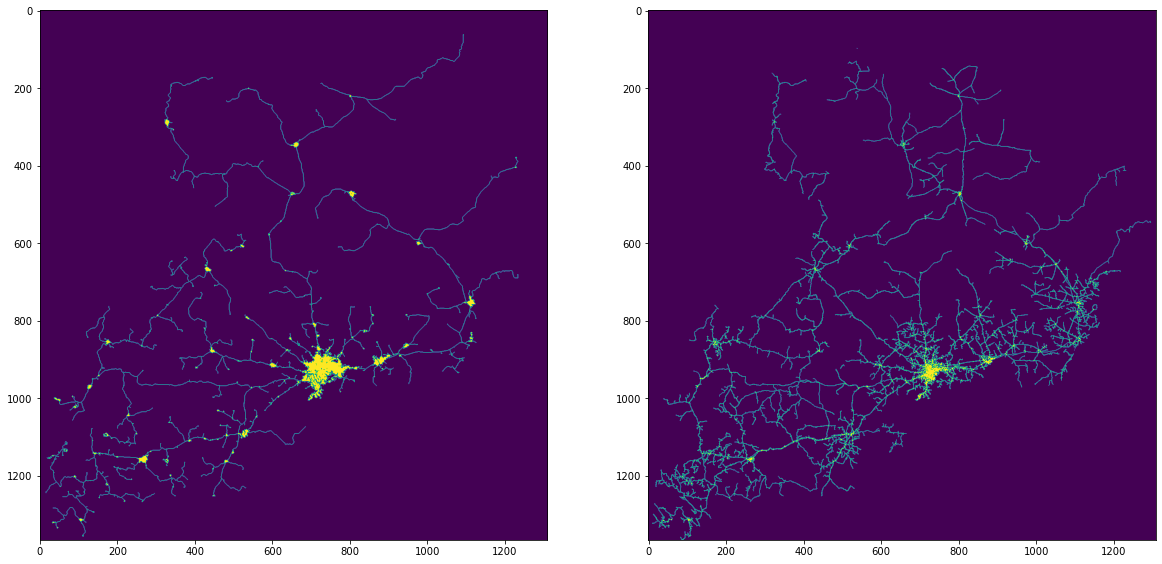

In [96]:
plt.figure(figsize=(20,12))
plt.title("Predicted Grid vs. Actual Grid")
plt.subplot(121)
plt.imshow(uganda_results['paths'])
plt.subplot(122)
plt.imshow(uganda_grid)
plt.savefig("results/uganda/predicted_grid_vs_actual_grid.png")

Number of targets (left image):  935463 
Number of targets (right image):  11756


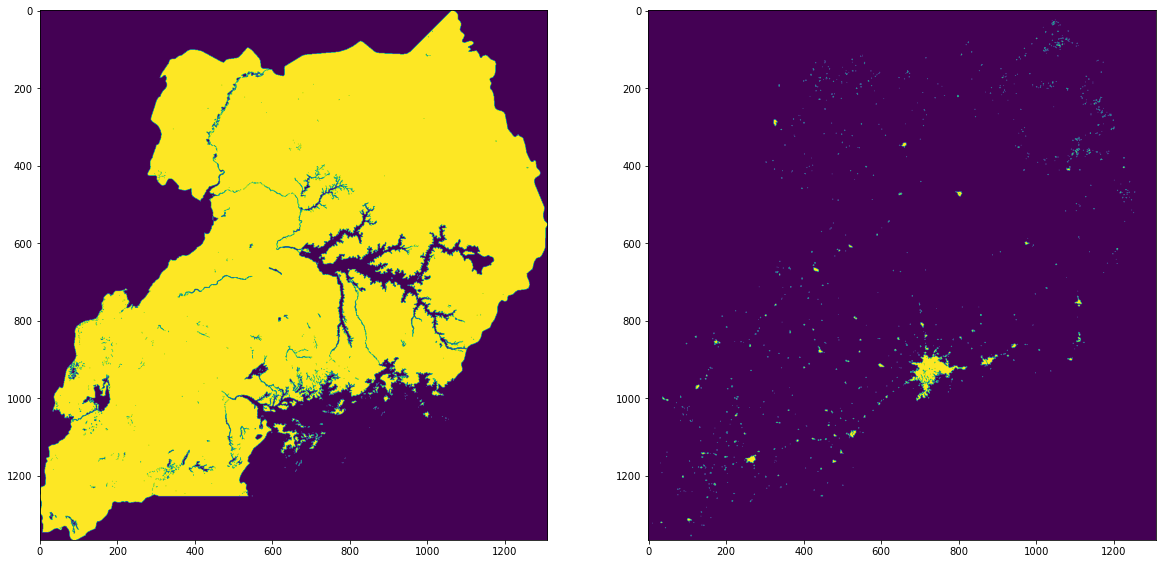

In [43]:
threshold_1 = 0.1
threshold_2 = 1

uganda_1 = (lambda x: x>threshold_1)(uganda)*1
uganda_2 = (lambda x: x>threshold_2)(uganda)*1
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(uganda_1)
plt.subplot(122)
plt.imshow(uganda_2)
plt.savefig(f"results/uganda/bv_threshold_{threshold_1}_vs_{threshold_2}.png")
print('Number of targets (left image): ', uganda_1.sum(), '\nNumber of targets (right image): ', uganda_2.sum())

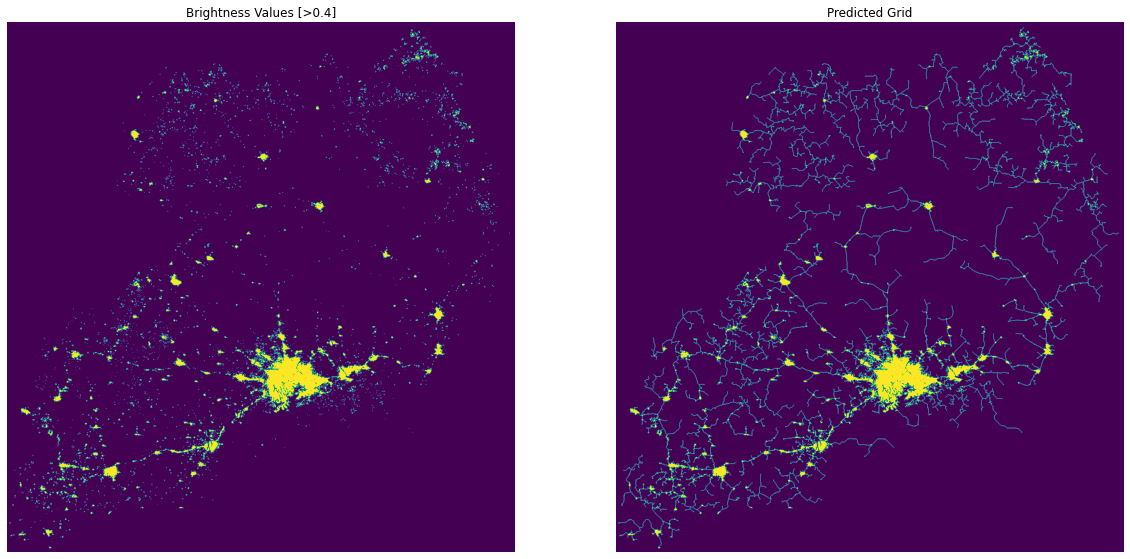

In [38]:
uganda_origins = (lambda x: x>0.4)(uganda)*1

plt.figure(figsize=(20,12))
plt.subplot(121)
plt.title('Brightness Values [>0.4]')
plt.axis('off')
plt.imshow(uganda_origins)
plt.subplot(122)
plt.title('Predicted Grid')
plt.axis('off')
plt.imshow(uganda_results['paths'])
plt.savefig("results/uganda/origins_and_paths.png")

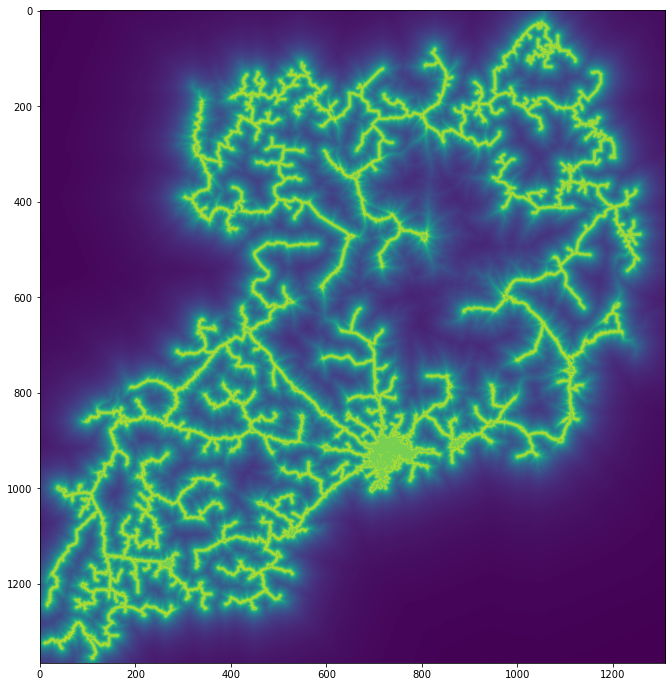

In [49]:
# 41.65096290848922 97.47127388157446 16.695530417480377
# 40.566075343830974 97.40975586294681 18.013170006372583 with bv_threshold = 0.7
# 53.44184027777777 97.76314891722694 23.53852035939591  with different weighting on roads
# 50.46799802948199 97.68826471091565 24.367841329088446 with bv_threshold = 0.6 and roads weighting
# 45.72447670598542 97.52160680590617 24.798913965722043 with bv_threshold = 0.5 and roads weighting
plt.figure(figsize=(20,12))
plt.imshow(uganda_results['rendering'])

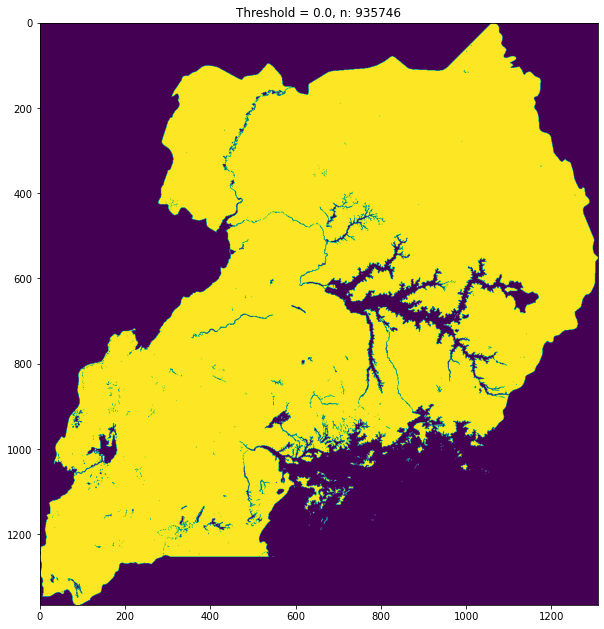

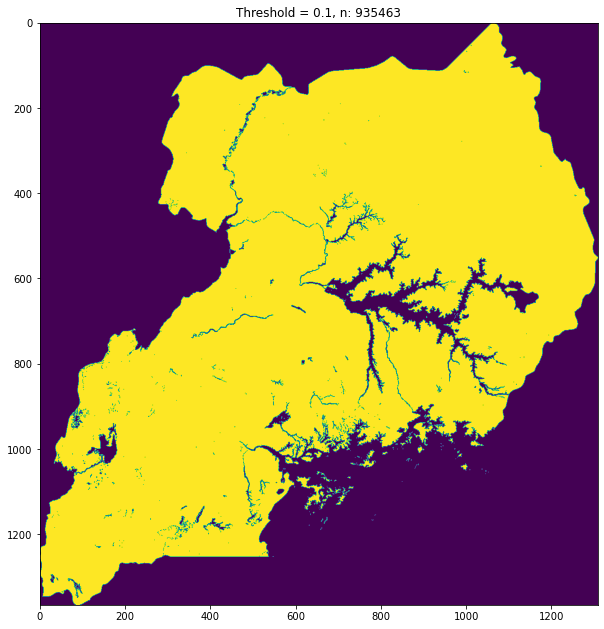

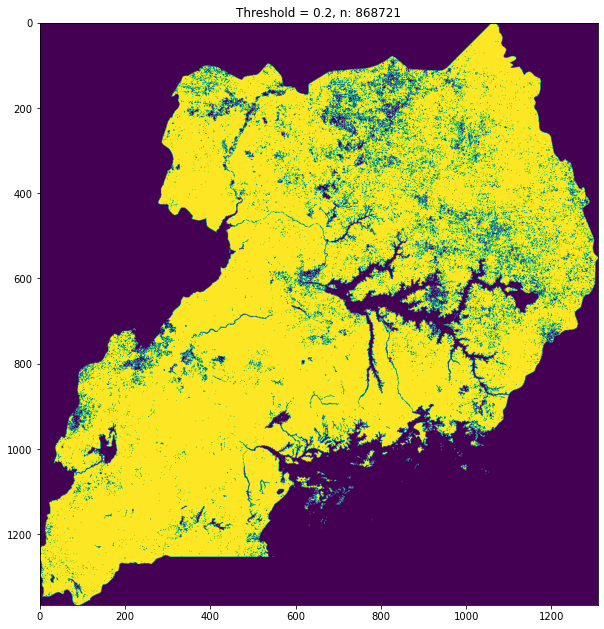

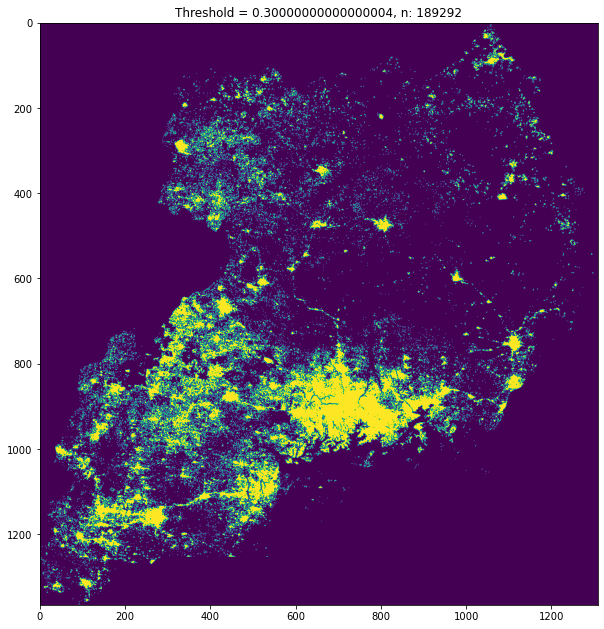

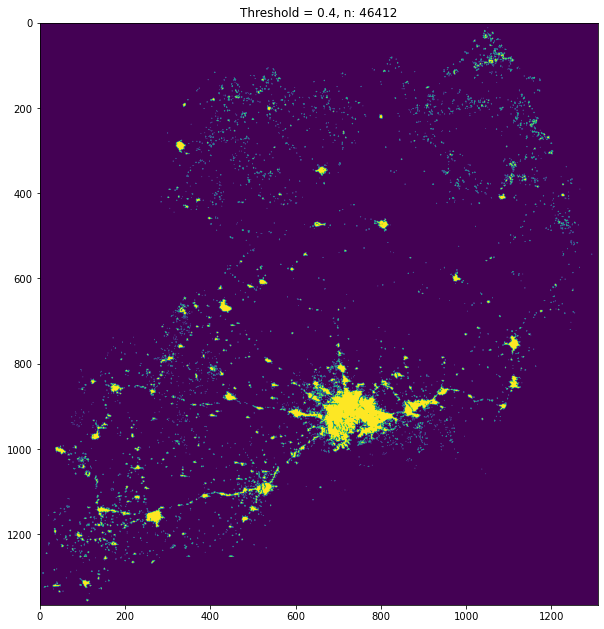

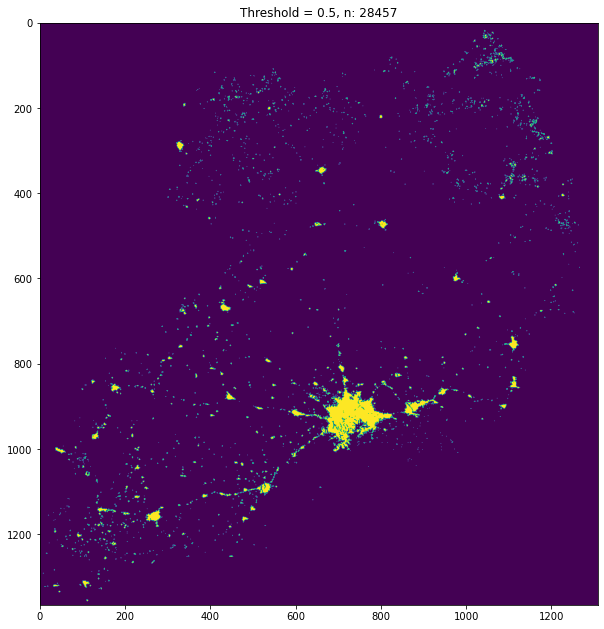

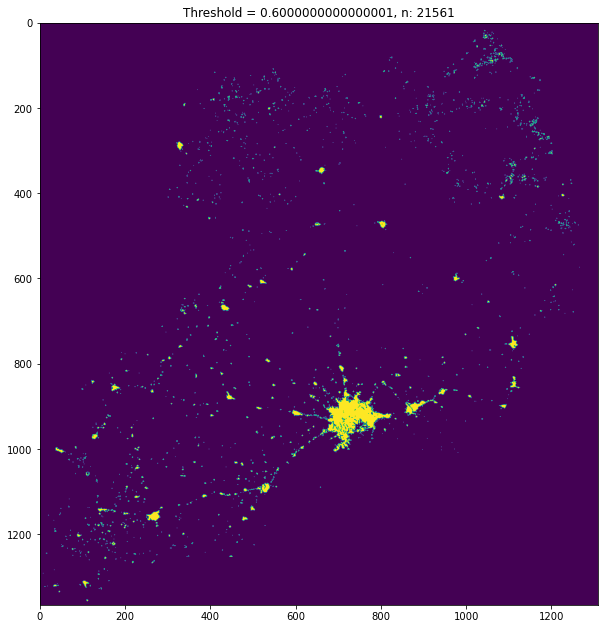

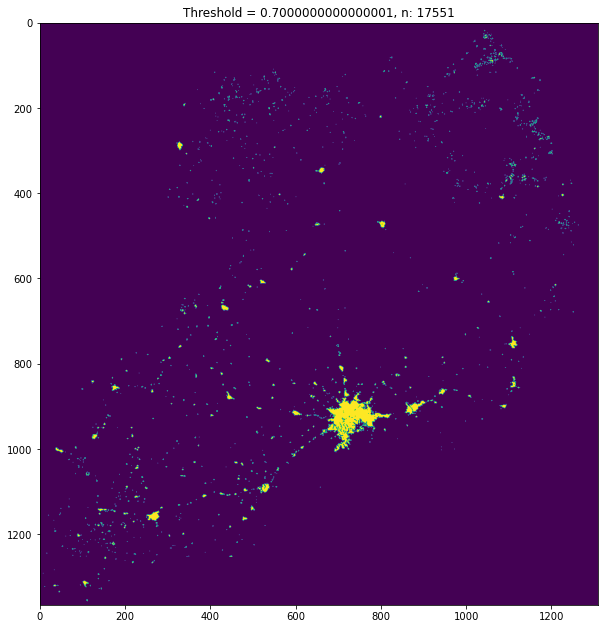

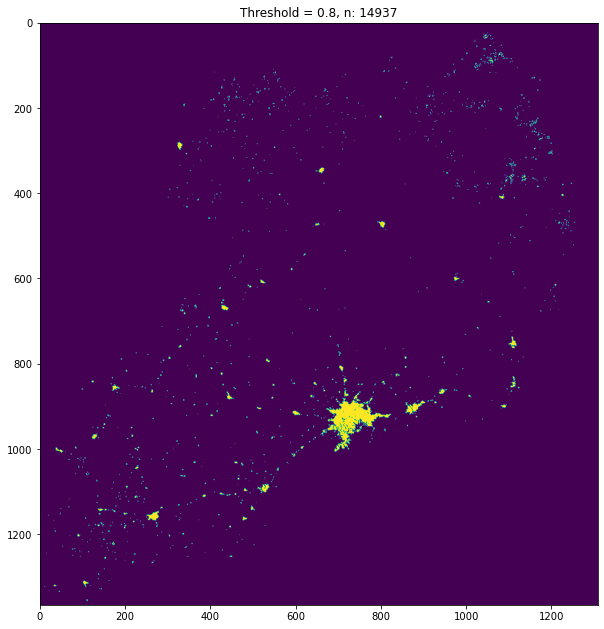

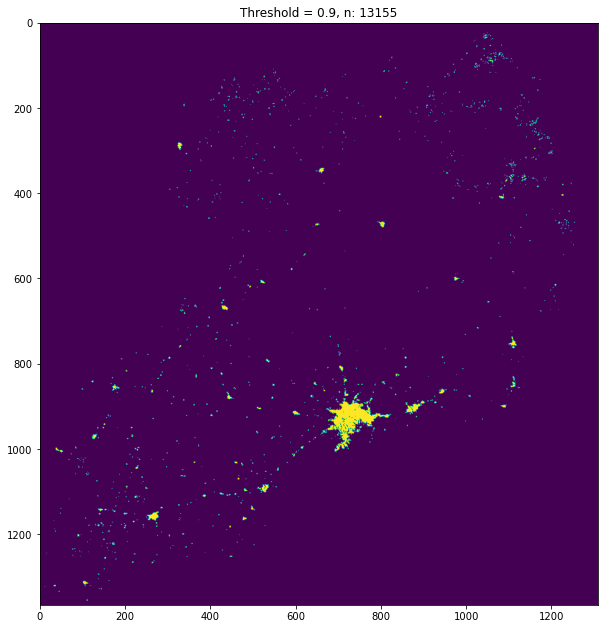

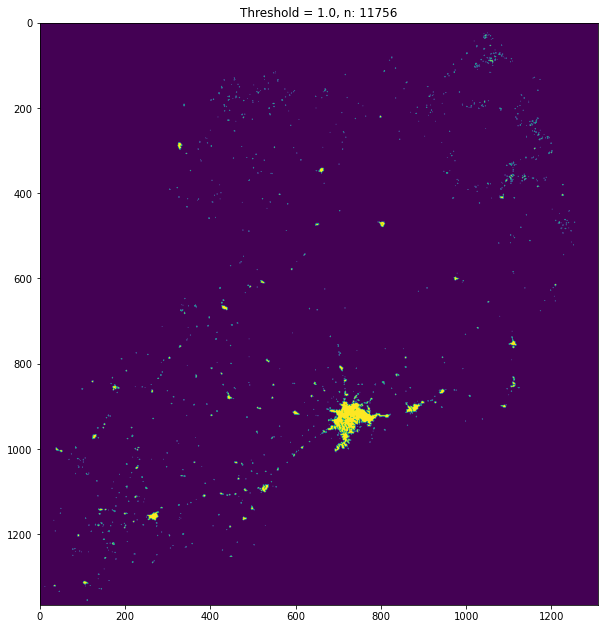

In [46]:
ts = np.linspace(0, 1, 11)
for threshold in ts:
    uganda_1 = (lambda x: x>threshold)(uganda)*1
    plt.figure(figsize=(10,12))
    plt.imshow(uganda_1)
    plt.title(f'Threshold = {threshold}, n: {uganda_1.sum()}')
    plt.savefig(f"results/uganda/bv_threshold_{threshold}.png")

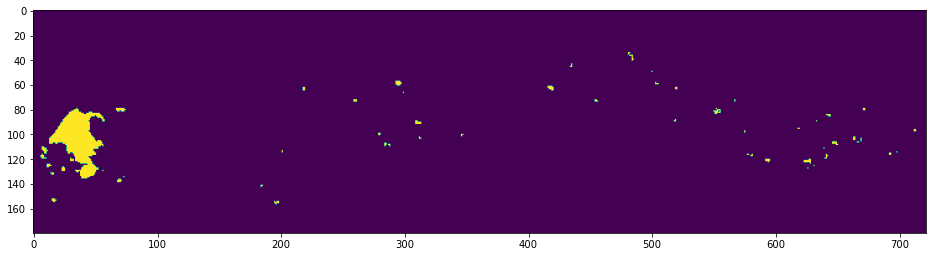

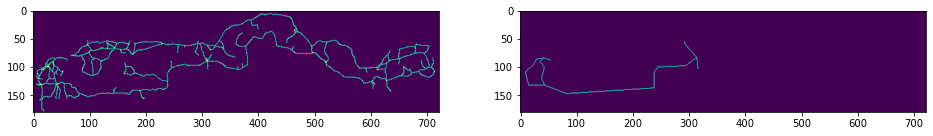

In [69]:
gambia = Image.open('bv/bv_gambia.tif')
gambia = np.array(gambia)
gambia_targets = (lambda x:x>1)(gambia)

gambia_roads = Image.open('datasets/gambia/highways.tif')
gambia_roads = np.array(gambia_roads)
gambia_roads = (lambda x:x==2)(gambia_roads)*1

gambia_hv_grid = Image.open('datasets/gambia/hv_grid.tif')
gambia_hv_grid = np.array(gambia_hv_grid)
gambia_hv_grid = (lambda x: x>1)(gambia_hv_grid)*1

plt.figure(figsize=(16,9))
plt.imshow(gambia_targets)
plt.figure(figsize=(16,9))
plt.subplot(221)
plt.imshow(gambia_roads)
plt.subplot(222)
plt.imshow(gambia_hv_grid)


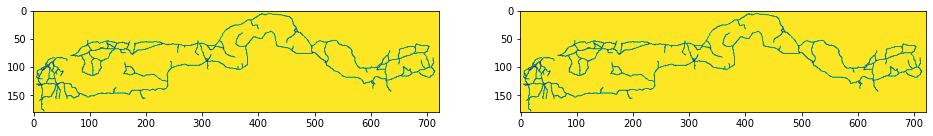

In [70]:
gambia_random_origin = np.zeros(gambia_targets.shape)
gambia_random_origin[100][30] = 1

gambia_weights = np.ones(gambia_roads.shape)
plt.figure(figsize=(16,9))
gambia_weights = update_weights_with_roads(gambia_weights, gambia_roads)
plt.subplot(121)
plt.imshow(gambia_weights)
#gambia_weights = update_weights_with_grid(gambia_weights, gambia_hv_grid)
plt.subplot(122)
plt.imshow(gambia_weights)

In [71]:
gambia_hv_weights_results = seek(
    gambia_random_origin,
    targets=gambia_targets,
    weights=gambia_weights
)

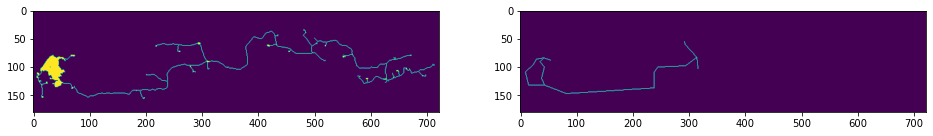

In [72]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(gambia_hv_weights_results['paths'])
plt.subplot(122)
plt.imshow(gambia_hv_grid)
plt.savefig(os.getcwd() + '/hv_origins_grid.png')

(array([128453,      0,      0,      0,      0,      0,      0,      0,
             0,   1507]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]))

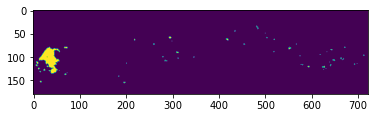

In [45]:
diff = gambia_hv_origin_results['paths']-gambia_hv_weights_results['paths']
plt.imshow(diff)
np.histogram(diff)

In [47]:
africa = Image.open('bv/africa.tif')
plt.imshow(africa)

DecompressionBombError: Image size (372831684 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.